In [1]:
import random as rd
import numpy as np
from itertools import product
from scipy import optimize
import datetime
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
#Generating pairwise correlations of 10 sectors
M2_S = np.zeros((10,10))
for i,j in product (range(0,10),range(0,10)):
    if (i==j):
        M2_S[i][j] = 1.0
    else:
        if (i>j):
            M2_S[i][j] = rd.uniform(-1.0,1.0)
            M2_S[j][i] = M2_S[i][j]   

In [2]:
#Correlation matrix of 100 stocks based on their sector structure

def tanh(x):
    for (k,i,j) in product(range(0,61), range(0,100), range(0,100)):
        x[k][i][j] = np.tanh(x[k][i][j])


def daily_correlation(sigma):
    daily_corr = np.zeros((61, 100, 100))
    for (i, j) in product (range(0,100), range(0,100)):
        if (i>j):
            daily_corr[0][i][j] = np.random.normal(M2_S[i/10][j/10], sigma, 1)
            daily_corr[0][j][i] = daily_corr[0][i][j]
        else:
            if (i==j):
                daily_corr[0][i][j] = 1.0
        for k in range(1, 61):
            if (i>j):
                daily_corr[k][i][j] = np.random.normal(daily_corr[k-1][i][j], sigma, 1)
                daily_corr[k][j][i] = daily_corr[k][i][j]
            else:
                if (i==j):
                    daily_corr[k][i][j] = 1.0  
    tanh(daily_corr)
    return daily_corr

daily_corr = daily_correlation(0.3)




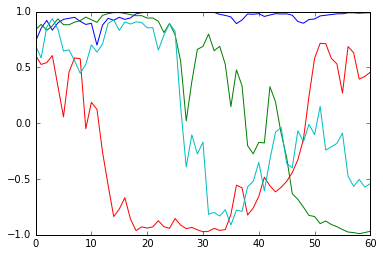

In [3]:
 #Plots showing evolution of the correlations between some stocks
def plots(daily_corr):       
    a,b,c,d = [],[],[],[]
    for i in range (0,61):
        a.append(daily_corr[i][9][94])
        b.append(daily_corr[i][97][95])
        c.append(daily_corr[i][10][11])
        d.append(daily_corr[i][10][12])

    plt.plot(a, 'r', b, 'b', c, 'g', d, 'c')
    plt.show()

    
plots(daily_corr)

In [4]:
#Generating samples of stock returns based on their correlations over 61 days
def return_generator(N_samples, daily_corr):
    mu = np.zeros(100)
    returns = []
    for k in range(0,61):
        returns.append(np.random.multivariate_normal(mu, daily_corr[k], N_samples))
    last_returns = returns[60]
    returns = np.swapaxes(np.delete(returns, 60, axis=0), 0, 1)
    return returns, last_returns

In [5]:
#Empirical models for correlation matrices of stock returns constructed from 60 days
#model1 - straight-forward empirical
#model2 - with respect to the knowledge of underlying sector structure
#r1 - sample returns on the 61st day
def empiric_models(N_samples, daily_corr):
    r0, r1 = return_generator(N_samples, daily_corr)
    model1 = []
    model2 = np.zeros((N_samples, 100, 100))
    sector_average_corr = np.zeros((N_samples, 10, 10))
    for k in range(0, N_samples):
        model1.append(np.corrcoef(r0[k].transpose()))
        for (i,j) in product(range(0,10), range(0,10)):         
            if (i>j):
                sector_average_corr[k][i][j] = np.mean(model1[k][i*10:(i+1)*10, j*10:(j+1)*10])
                sector_average_corr[k][j][i] = sector_average_corr[k][i][j]
            else:
                if (i==j):
                    sector_average_corr[k][i][j] = (np.sum(model1[k][i*10:(i+1)*10, j*10:(j+1)*10])-10)/90
        for (i,j) in product(range(0,100), range(0,100)):
            if (i==j):
                model2[k][i][j] = 1.0
            else:
                model2[k][i][j] = sector_average_corr[k][i/10][j/10]
    return model1, model2, r1
    


In [6]:
#Weights for standard minimum variance Markowitz portfolio
bnds = []
for i in range(0,100):
    bnds.append((0, None))
bnds = tuple(bnds)
cons_sum = ({'type': 'eq', 'fun': lambda x: np.sum(x)-1})
def portfolio_variance(x, matrix):
    p_var = np.dot(np.dot(x, matrix), x)
    return p_var
def grad_portfolio_var(x, matrix):
    grad = []
    for i in range(0,100):
        s = np.dot(matrix[i], x)+matrix[i][i]*x[i]
        grad.append(s)
    return grad
def weights(matrix, number_of_weights):
    x0 = (1./number_of_weights)*np.ones(number_of_weights)
    res = optimize.minimize(portfolio_variance, x0, args=(matrix), method = 'SLSQP',
                            jac = grad_portfolio_var, bounds=bnds, constraints=cons_sum,
                            options={'maxiter': 100})
    return res.x

In [7]:
#Error function for sample/out_of_sample as variance of optimal portfolio returns
#range_of_sample - range on which we estimate optimal weights
#out_of_sample range is set to be 200
m2 = np.identity(100)
def error(x, sample_or_not, range_of_sample):
    if (sample_or_not=='sample'):
        boundary0 = 0
        boundary1 = range_of_sample
    if (sample_or_not=='out_of_sample'):
        boundary0 = N_samples - range_of_sample
        boundary1 = N_samples
    portfolio_returns = []
    for k in range (boundary0, boundary1):
        m = x[0]*m0[k] + x[1]*m1[k] + (1-x[0]-x[1])*m2
        w = weights(m, 100)
        portfolio_returns.append(np.dot(w, r1[k]))
    return np.var(portfolio_returns)

In [8]:
#Optimizing model weights with positivity constraints 
#Function depending on the range_of_sample
cons = ({'type': 'ineq', 'fun': lambda x: x[0]},
       {'type': 'ineq', 'fun': lambda x: x[1]},
       {'type': 'ineq', 'fun': lambda x: 1-x[0]-x[1]})
def optimal_model_weights(a):
    x0 = [0.5, 0.3]
    start_time = datetime.datetime.now()
    res = optimize.minimize(error, x0, args=('sample', a), method='COBYLA',
                       constraints=cons,
                       options={'maxiter': 100})
    return datetime.datetime.now() - start_time, res.x, res.fun


In [9]:
times = []
results = []
sample_error = []
out_of_sample_error = []
sigma_values = np.linspace(0.1, 1.0, 10)
range_of_sample = [100, 200, 500, 1000, 2000, 5000]
N_samples = 5200
for sigma in sigma_values:
    daily_corr = daily_correlation(sigma)
    m0, m1, r1 = empiric_models(N_samples, daily_corr)
    for i in range_of_sample:
        local_results, local_sample_error, local_times, local_out_of_sample_error = [], [], [], []
        time, result, err = optimal_model_weights(i)
        local_sample_error.append(err)
        local_results.append([result[0], result[1], 1-result[0]-result[1]])
        local_times.append(time)
        print time, result, err
        e = error(result, 'out_of_sample', 200)
        print e
        local_out_of_sample_error.append(e)
    results.append(local_results)
    times.append(local_times)
    sample_error.append(local_sample_error)
    out_of_sample_error.append(local_out_of_sample_error)


C:\Users\Mikhail\Anaconda2\lib\site-packages\ipykernel\__main__.py:6: RuntimeWarning: covariance is not positive-semidefinite.
C:\Users\Mikhail\Anaconda2\lib\site-packages\scipy\optimize\slsqp.py:337: RuntimeWarning: invalid value encountered in greater
  bnderr = where(bnds[:, 0] > bnds[:, 1])[0]


0:05:24.372000 [ 0.42436923  0.57563077] 0.0257776301541
0.027303323544
0:10:20.355000 [ 0.47739557  0.52246318] 0.0253950173877
0.0271487183569
0:21:44.190000 [ 0.55764199  0.44221659] 0.0266921188161
0.0271409855626
0:46:50.338000 [ 0.41208104  0.58791896] 0.0250256494222
0.0272160799189
1:32:54.896000 [ 0.40071844  0.59928156] 0.0246417225411
0.0273113128928
3:44:44.696000 [ 0.39087833  0.60912167] 0.0252756455517
0.0272180757779
0:04:43.991000 [ 0.59950193  0.40049807] 0.0371400257468
0.0416052761667
0:08:02.684000 [ 0.64879279  0.35106579] 0.0352327550357
0.0413777573514
0:18:23.290000 [ 0.64920957  0.35064902] 0.0403874115989
0.0413752644087
0:41:47.638000 [ 0.60721812  0.39278188] 0.0425231856624
0.0414850585749
1:25:21.875000 [ 0.59652626  0.40337553] 0.0450121381029
0.0415763812519
3:24:40.749000 [ 0.7793744  0.2206256] 0.043662819128
0.0414282982791
0:03:10.158000 [ 0.91281683  0.08718317] 0.0296268060134
0.0307929801206
0:05:16.542000 [ 0.52934761  0.4706494 ] 0.031537394789

In [15]:
a = [[ 0.42436923,  0.57563077], 0.0257776301541,
0.027303323544,
[ 0.47739557,  0.52246318], 0.0253950173877,
0.0271487183569,
[ 0.55764199 , 0.44221659], 0.0266921188161,
0.0271409855626,
[ 0.41208104  ,0.58791896], 0.0250256494222,
0.0272160799189,
[ 0.40071844  ,0.59928156], 0.0246417225411,
0.0273113128928,
[ 0.39087833,  0.60912167], 0.0252756455517,
0.0272180757779,
[ 0.59950193 , 0.40049807], 0.0371400257468,
0.0416052761667,
[ 0.64879279  ,0.35106579], 0.0352327550357,
0.0413777573514,
[ 0.64920957 , 0.35064902], 0.0403874115989,
0.0413752644087,
[ 0.60721812 , 0.39278188], 0.0425231856624,
0.0414850585749,
[ 0.59652626 , 0.40337553], 0.0450121381029,
0.0415763812519,
[ 0.7793744  ,0.2206256], 0.043662819128,
0.0414282982791,
[ 0.91281683 , 0.08718317], 0.0296268060134,
0.0307929801206,
[ 0.52934761 , 0.4706494 ], 0.0315373947898,
0.0299307397637,
[ 0.69821654 , 0.27185402], 0.0305940688309,
0.030190395599,
[ 0.43271063 , 0.40546729], 0.0303103361924,
0.0307255698137,
[ 0.68372205 , 0.3161518 ], 0.0302636253712,
0.0301757998992,
[ 0.68214353 , 0.3166371 ], 0.0296050453961,
0.0302258250114,
[ 0.50165105 , 0.31616619], 0.0315649085044,
0.0417846801617,
[ 0.48362499 , 0.35925043], 0.039880162048,
0.0416906749003,
[ 0.48381523 , 0.34272292], 0.0409849151965,
0.0418613542731,
[ 0.50550233 , 0.36109939], 0.0420767080923,
0.0416729136954,
[ 0.60226276 , 0.39773724], 0.0415875384265,
0.0414971188235,
[ 0.63528185 , 0.36457074], 0.0432055036662,
0.0413105264424,
[ 0.8994176 , 0.1005824], 0.0500427058467,
0.0434168317483,
[ 0.98956538 , 0.00137476], 0.0466499766163,
0.0434517940716,
[  1.00000000e+00 , -4.16333634e-17], 0.0457384510694,
0.0435692832018,
[ 0.99778698 , 0.00221302], 0.0487559580617,
0.0435608567439,
[ 0.9422697 , 0.0577303], 0.0465276695867,
0.0435520033437,
[ 0.93428788 , 0.06571212], 0.0454374754568,
0.0435179953677,
[ 0.50432487 , 0.29787595], 0.0529229023413,
0.0565660836315,
[ 0.99868964 , 0.00131036], 0.0524772707937,
0.055705503596,
[ 0.80212033 , 0.19775118], 0.0536935418917,
0.0554573497122,
[ 0.91352809 , 0.0834676 ], 0.0549922081835,
0.054812469904,
[ 0.82234041 , 0.17532403], 0.0570891450384,
0.0550319906817,
[ 0.88947557 , 0.11052443], 0.0577682680182,
0.0545665986687,
[ 0.72633725 , 0.        ], 0.0342442844379,
0.0293449564556,
[ 0.74786288 , 0.16106999], 0.0336546140974,
0.0292760762642,
[  7.00095313e-01 ,  9.62964972e-35], 0.0339343613028,
0.0293847782104,
[  9.22332447e-01 , -1.35525272e-20], 0.0320162671638,
0.029157005523,
[  9.14839063e-01 , -1.09778007e-32], 0.0322807420705,
0.0291358332751,
[  1.00000000e+00 , -2.77555756e-17], 0.0339796406051,
0.0288240044718,
[ 0.78066187 , 0.        ], 0.0444901254744,
0.0442123140528,
[  7.80900334e-01 ,  1.25702512e-04], 0.0452884745231,
0.0442124250235,
[ 0.84150589 , 0.        ], 0.0474562981037,
0.0447385304815,
[  8.14353383e-01 ,  4.81098794e-04], 0.0477046055588,
0.044431374661,
[ 0.94110625 , 0.        ], 0.045764197787,
0.0446773966848,
[ 0.88288962 , 0.        ], 0.0450040010448,
0.0447289343577,
[  1.00000000e+00 , -4.16333634e-17], 0.031172044812,
0.0445951087567,
[  1.00000000e+00 , -4.16333634e-17], 0.0311230738206,
0.0445951087567,
[ 0.93100903 , 0.06899097], 0.0339781171064,
0.0442096525368,
[ 0.61427313 , 0.38572687], 0.037411715102,
0.0432104565333,
[ 0.94461586 , 0.05538414], 0.0364764134607,
0.0441732056351,
[ 0.87248527 , 0.12751473], 0.037546461641,
0.0439574534726,
[  5.76296866e-01 ,  2.70434125e-04], 0.0616429143559,
0.055015186269,
[ 0.63813951 , 0.00747927], 0.0619972523532,
0.0544419609098,
[  4.39625722e-01 , -2.25795163e-47], 0.0664246741726,
0.0560291956786,
[  3.42648121e-01 , -5.55111512e-21], 0.0602863841578,
0.0570715512304,
[ 0.26889676 , 0.0536657 ], 0.0562107085214,
0.0571699079472,
[ 0.25612891 , 0.01607871], 0.0561739865077,
0.0576555127876  ]

In [20]:
results, sample_error, out_of_sample_error = [], [], []
for i in range(0,10):
    local_results = []
    local_out_of_sample_error = []
    local_sample_error = []
    for j in range(0,6):
        local_results.append(a[18*i+3*j])
        local_sample_error.append(a[18*i+3*j+1])
        local_out_of_sample_error.append(a[18*i+3*j+2])
    results.append(local_results)
    sample_error.append(local_sample_error)
    out_of_sample_error.append(local_out_of_sample_error)
print results
print sample_error
print out_of_sample_error

[[[0.42436923, 0.57563077], [0.47739557, 0.52246318], [0.55764199, 0.44221659], [0.41208104, 0.58791896], [0.40071844, 0.59928156], [0.39087833, 0.60912167]], [[0.59950193, 0.40049807], [0.64879279, 0.35106579], [0.64920957, 0.35064902], [0.60721812, 0.39278188], [0.59652626, 0.40337553], [0.7793744, 0.2206256]], [[0.91281683, 0.08718317], [0.52934761, 0.4706494], [0.69821654, 0.27185402], [0.43271063, 0.40546729], [0.68372205, 0.3161518], [0.68214353, 0.3166371]], [[0.50165105, 0.31616619], [0.48362499, 0.35925043], [0.48381523, 0.34272292], [0.50550233, 0.36109939], [0.60226276, 0.39773724], [0.63528185, 0.36457074]], [[0.8994176, 0.1005824], [0.98956538, 0.00137476], [1.0, -4.16333634e-17], [0.99778698, 0.00221302], [0.9422697, 0.0577303], [0.93428788, 0.06571212]], [[0.50432487, 0.29787595], [0.99868964, 0.00131036], [0.80212033, 0.19775118], [0.91352809, 0.0834676], [0.82234041, 0.17532403], [0.88947557, 0.11052443]], [[0.72633725, 0.0], [0.74786288, 0.16106999], [0.700095313, 9.6

One division of x-axis corresponds to 5000 range of sample


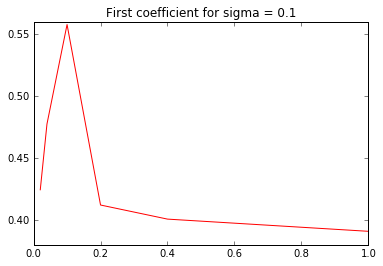

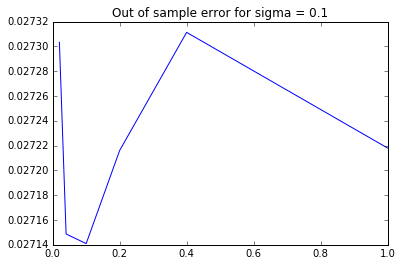

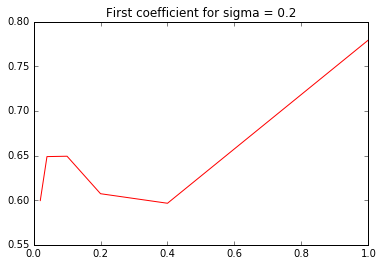

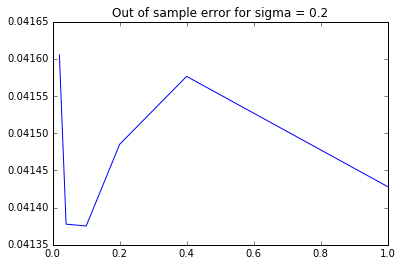

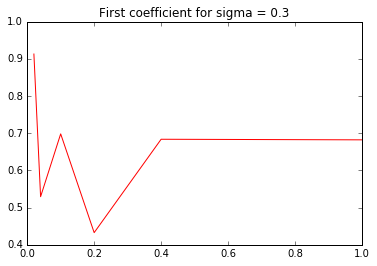

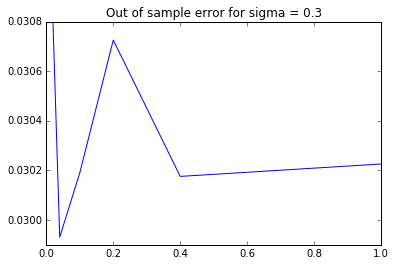

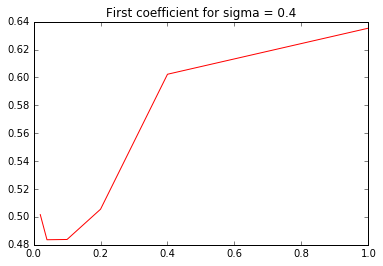

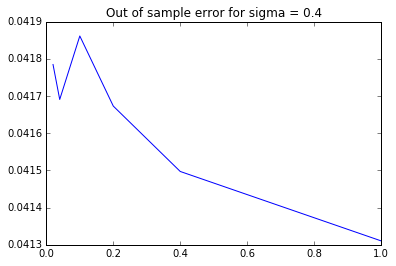

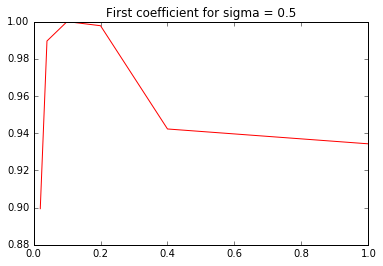

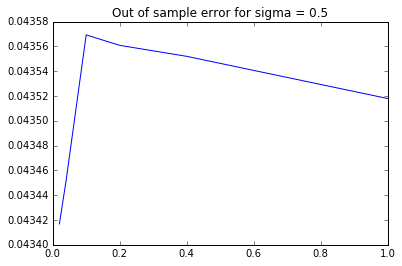

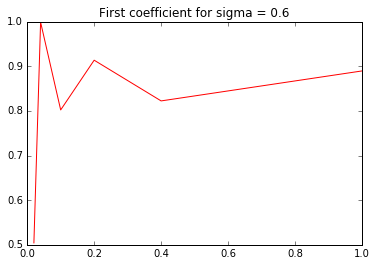

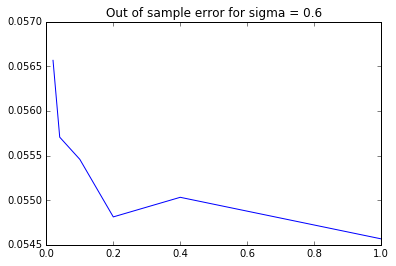

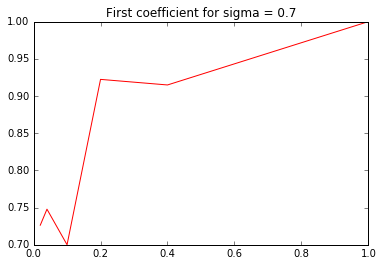

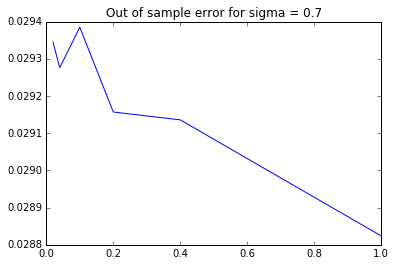

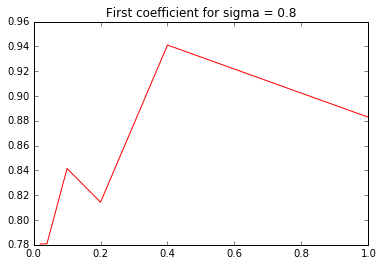

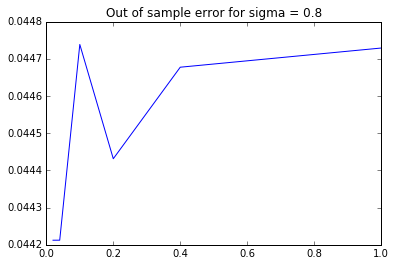

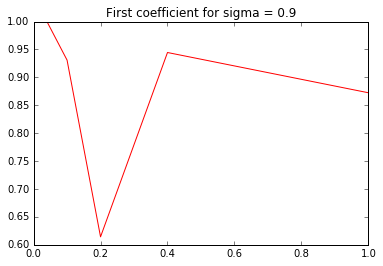

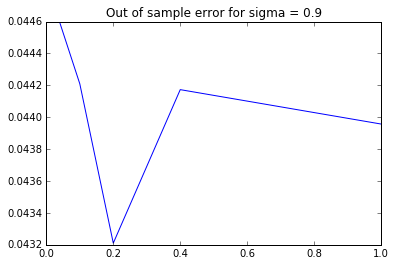

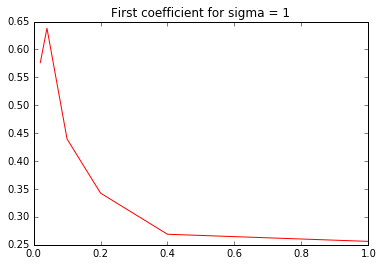

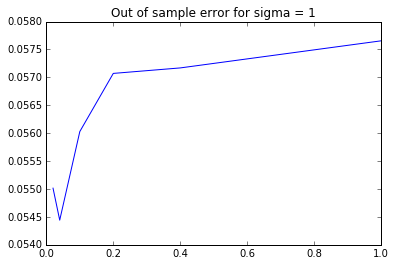

In [44]:
print 'One division of x-axis corresponds to 5000 range of sample'
scaled_range_of_sample = []
for i in range(0,6):
    scaled_range_of_sample.append(1./5000*range_of_sample[i])
for i in range(0,10):
    a = []
    for j in range(0,6):
        a.append(results[i][j][0])
    plt.plot(scaled_range_of_sample, a, 'r')
    plt.title('First coefficient for sigma = %lg' %sigma_values[i])
    plt.show()
    plt.plot(scaled_range_of_sample, out_of_sample_error[i])
    plt.title('Out of sample error for sigma = %lg' %sigma_values[i])
    plt.show()